In [1]:
import json
import requests
from bs4 import BeautifulSoup, Comment
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
with open(".json", "r") as file:
    source_dict = json.load(file)

SOURCE_URL, STATISTICS_DICT = source_dict["source_url"], source_dict["statistics"]
AXES_PER_ROW = 4

### Question 1

In [3]:
stats = None

for key, value in STATISTICS_DICT.items():
    container_divs = value["container-divs"]
    columns = value["columns"]

    response = requests.get(SOURCE_URL.format(key))
    html = BeautifulSoup(response.text, features="html.parser")

    stats_div = html.find("body").find(id="wrap").find(id="content").find(id=container_divs[0])
    comment = stats_div.find(string=lambda text: isinstance(text, Comment))
    table = BeautifulSoup(comment, features="html.parser").find(id=container_divs[1]).find("table")

    tr_list = table.find("tbody").find_all("tr")
    tr_list = [tr for tr in tr_list if not tr.has_attr("class")]
    stats_list = []
    for tr in tr_list:
        player_stats = {td.get("data-stat"): td.text for td in tr.find_all("td") if td.get("data-stat") in columns}
        stats_list.append(player_stats)

    if isinstance(stats, pd.DataFrame):
        stats = stats.merge(
            pd.DataFrame(stats_list).set_index(["player", "team"]),
            on=["player", "team"],
            how="left"
        )
    else:
        stats = pd.DataFrame(stats_list).set_index(["player", "team"])
        stats["minutes"] = stats["minutes"].str.replace(",", "").astype(float)
        stats = stats[stats["minutes"] >= 90]

stats

,,nationality,position,age,minutes,goals_assists,goals_pens,npxg_xg_assist,goals_per90,assists_per90,goals_assists_per90,...,cards_red,fouls,fouled,offsides,crosses,own_goals,ball_recoveries,aerials_won,aerials_lost,aerials_won_pct
player,team,,,,,,,,,,,,,,,,,,,,,
Max Aarons,Bournemouth,eng ENG,DF,23,1237.0,1,0,0.9,0.00,0.07,0.07,...,0,12,26,2,13,0,75,5,11,31.3
Tyler Adams,Bournemouth,us USA,MF,24,121.0,0,0,0.1,0.00,0.00,0.00,...,0,0,3,0,1,0,7,2,3,40.0
Tosin Adarabioyo,Fulham,eng ENG,DF,25,1617.0,2,2,0.8,0.11,0.00,0.11,...,0,10,5,0,1,0,43,56,28,66.7
Elijah Adebayo,Luton Town,eng ENG,FW,25,1419.0,10,10,6.6,0.63,0.00,0.63,...,0,27,16,13,5,0,34,43,43,50.0
Simon Adingra,Brighton,ci CIV,FW,21,2222.0,7,6,8.0,0.24,0.04,0.28,...,0,29,19,17,76,0,118,8,12,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Nicolò Zaniolo,Aston Villa,it ITA,"FW,MF",24,839.0,2,2,3.6,0.21,0.00,0.21,...,0,24,21,0,18,0,36,7,14,33.3
Anass Zaroury,Burnley,ma MAR,"FW,MF",22,152.0,0,0,0.2,0.00,0.00,0.00,...,1,4,3,0,11,0,8,0,1,0.0
Oleksandr Zinchenko,Arsenal,ua UKR,DF,26,1722.0,3,1,3.1,0.05,0.10,0.16,...,0,7,9,1,30,0,104,27,16,62.8


In [25]:
stats["nationality"] = stats["nationality"].str.replace(r"[a-z]", "", regex=True)
stats = stats.replace("", np.nan)

statistical_columns = stats.columns.difference(["nationality", "position"])
statistical_columns.name = "statistical_columns"
stats[statistical_columns] = stats[statistical_columns].astype(float)
stats.dtypes

nationality         object
position            object
age                float64
minutes            float64
goals_assists      float64
                    ...   
own_goals          float64
ball_recoveries    float64
aerials_won        float64
aerials_lost       float64
aerials_won_pct    float64
Length: 158, dtype: object

In [26]:
# stats.reset_index().sort_values(by=["player", "age"], ascending=[True, False]).set_index(["player", "team"]).to_csv("result/results.csv", index=True)

### Question 2

In [27]:
top_and_bottom_stats = pd.concat([
    stats[statistical_columns].apply(lambda col: col.nsmallest(3).sort_values().index.values).set_axis([-3, -2, -1]),
    stats[statistical_columns].apply(lambda col: col.nlargest(3).sort_values().index.values).set_axis([1, 2, 3])
])
top_and_bottom_stats

,aerials_lost,aerials_won,aerials_won_pct,age,assisted_shots,assists,assists_per90,average_shot_distance,ball_recoveries,blocked_passes,...,touches_live_ball,touches_mid_3rd,unused_subs,xg,xg_assist,xg_assist_net,xg_assist_per90,xg_net,xg_per90,xg_xg_assist_per90
-3,"(Daniel Bentley, Wolves)","(Maxwel Cornet, West Ham)","(Maxwel Cornet, West Ham)","(Leon Chiwome, Wolves)","(Jaidon Anthony, Bournemouth)","(Tyler Adams, Bournemouth)","(Tyler Adams, Bournemouth)","(Tim Ream, Fulham)","(Loris Karius, Newcastle Utd)","(Alisson, Liverpool)",...,"(Leon Chiwome, Wolves)","(Dean Henderson, Crystal Palace)","(Elijah Adebayo, Luton Town)","(Max Aarons, Bournemouth)","(Naouirou Ahamada, Crystal Palace)","(Dejan Kulusevski, Tottenham)","(Alisson, Liverpool)","(Dominic Calvert-Lewin, Everton)","(Max Aarons, Bournemouth)","(Alisson, Liverpool)"
-2,"(Martin Dúbravka, Newcastle Utd)","(Mahmoud Dahoud, Brighton)","(Mahmoud Dahoud, Brighton)","(Lewis Miley, Newcastle Utd)","(Alphonse Areola, West Ham)","(Tosin Adarabioyo, Fulham)","(Tosin Adarabioyo, Fulham)","(Andrew Omobamidele, Nott'ham Forest)","(Ionuț Radu, Bournemouth)","(Alphonse Areola, West Ham)",...,"(Neal Maupay, Everton)","(Loris Karius, Newcastle Utd)","(Anel Ahmedhodžić, Sheffield Utd)","(Tyler Adams, Bournemouth)","(Alisson, Liverpool)","(Bruno Fernandes, Manchester Utd)","(Jaidon Anthony, Bournemouth)","(Brennan Johnson, Tottenham)","(Tyler Adams, Bournemouth)","(Alphonse Areola, West Ham)"
-1,"(Ederson, Manchester City)","(Tommy Doyle, Wolves)","(Tommy Doyle, Wolves)","(Facundo Buonanotte, Brighton)","(Daniel Bentley, Wolves)","(Elijah Adebayo, Luton Town)","(Elijah Adebayo, Luton Town)","(Jonny Evans, Manchester Utd)","(Thomas Strakosha, Brentford)","(Daniel Bentley, Wolves)",...,"(Loris Karius, Newcastle Utd)","(Ionuț Radu, Bournemouth)","(Rayan Aït-Nouri, Wolves)","(Alisson, Liverpool)","(Jaidon Anthony, Bournemouth)","(Dominik Szoboszlai, Liverpool)","(Alphonse Areola, West Ham)","(Darwin Núñez, Liverpool)","(Alisson, Liverpool)","(Daniel Bentley, Wolves)"
1,"(Dominic Solanke, Bournemouth)","(Dominic Calvert-Lewin, Everton)","(Daniel Bentley, Wolves)","(Łukasz Fabiański, West Ham)","(Martin Ødegaard, Arsenal)","(Kevin De Bruyne, Manchester City)","(Kevin De Bruyne, Manchester City)","(Moisés Caicedo, Chelsea)","(Ryan Christie, Bournemouth)","(João Palhinha, Fulham)",...,"(Lewis Dunk, Brighton)","(William Saliba, Arsenal)","(Aaron Ramsdale, Arsenal)","(Alexander Isak, Newcastle Utd)","(Bruno Fernandes, Manchester Utd)","(Pedro Neto, Wolves)","(Sasa Kalajdzic, Wolves)","(Jean-Philippe Mateta, Crystal Palace)","(Erling Haaland, Manchester City)","(Erling Haaland, Manchester City)"
2,"(Dominic Calvert-Lewin, Everton)","(James Tarkowski, Everton)","(Martin Dúbravka, Newcastle Utd)","(Thiago Silva, Chelsea)","(Pascal Groß, Brighton)","(Cole Palmer, Chelsea)","(Ivan Perišić, Tottenham)","(Kyle Walker, Manchester City)","(Rodri, Manchester City)","(Tyrick Mitchell, Crystal Palace)",...,"(Pascal Groß, Brighton)","(Virgil van Dijk, Liverpool)","(Thomas Strakosha, Brentford)","(Mohamed Salah, Liverpool)","(Son Heung-min, Tottenham)","(Rodri, Manchester City)","(Ivan Perišić, Tottenham)","(Callum Hudson-Odoi, Nott'ham Forest)","(Neal Maupay, Everton)","(Neal Maupay, Everton)"
3,"(Carlton Morris, Luton Town)","(Virgil van Dijk, Liverpool)","(Ederson, Manchester City)","(Ashley Young, Everton)","(Bruno Fernandes, Manchester Utd)","(Ollie Watkins, Aston Villa)","(Manor Solomon, Tottenham)","(Oliver Norwood, Sheffield Utd)","(Bruno Guimarães, Newcastle Utd)","(Alexis Mac Allister, Liverpool)",...,"(Rodri, Manchester City)","(Rodri, Manchester City)","(Daniel Bentley, Wolves)","(Erling Haaland, Manchester City)","(Mohamed Salah, Liverpool)","(Ollie Watkins, Aston Villa)","(Kevin De Bruyne, Manchester City)","(Phil Foden, Manchester City)","(Kieffer Moore, Bournemouth)","(Kieffer Moore, Bournemouth)"


In [28]:
stats[statistical_columns].agg(["median", "mean", "std"])

,aerials_lost,aerials_won,aerials_won_pct,age,assisted_shots,assists,assists_per90,average_shot_distance,ball_recoveries,blocked_passes,...,touches_live_ball,touches_mid_3rd,unused_subs,xg,xg_assist,xg_assist_net,xg_assist_per90,xg_net,xg_per90,xg_xg_assist_per90
median,16.000000,12.000000,46.900000,25.000000,9.000000,1.000000,0.050000,16.300000,62.000000,11.000000,...,808.500000,313.500000,2.000000,1.100000,1.000000,-0.100000,0.070000,-0.100000,0.080000,0.170000
mean,20.402834,20.447368,48.338809,25.508097,15.923077,1.732794,0.099453,16.521542,74.030364,12.761134,...,957.874494,409.309717,4.912955,2.431174,1.751012,-0.018219,0.104352,-0.012146,0.148684,0.253158
std,20.973606,23.820838,21.536946,4.128137,18.475524,2.472046,0.137649,4.757655,55.885324,10.824416,...,716.002686,369.295732,6.431927,3.569450,2.192618,1.130614,0.106378,1.383082,0.177505,0.240054


In [29]:
team_stats_dict = {}

for column in statistical_columns:
    for statistic in ["median", "mean", "std"]:
        team_stats_dict[f"{statistic}_{column}"] = stats[column].groupby(level=1).agg(statistic)

team_stats = pd.DataFrame(team_stats_dict)
team_stats

,median_aerials_lost,mean_aerials_lost,std_aerials_lost,median_aerials_won,mean_aerials_won,std_aerials_won,median_aerials_won_pct,mean_aerials_won_pct,std_aerials_won_pct,median_age,...,std_xg_assist_per90,median_xg_net,mean_xg_net,std_xg_net,median_xg_per90,mean_xg_per90,std_xg_per90,median_xg_xg_assist_per90,mean_xg_xg_assist_per90,std_xg_xg_assist_per90
team,,,,,,,,,,,,,,,,,,,,,
Arsenal,16.0,23.619048,24.830377,15.0,23.809524,28.002891,48.80,48.830000,21.108868,24.0,...,0.125096,0.20,3.809524e-01,1.542277,0.120,0.198095,0.181621,0.240,0.337143,0.267939
Aston Villa,14.0,15.695652,16.457755,13.0,14.478261,12.943477,50.00,53.656522,22.613669,26.0,...,0.097482,0.00,3.043478e-01,1.508906,0.100,0.161304,0.156940,0.210,0.259130,0.212708
Bournemouth,21.0,25.653846,29.389716,15.0,22.192308,23.901497,42.10,45.768000,21.677518,24.5,...,0.097119,-0.10,-1.884615e-01,1.079380,0.060,0.192308,0.303833,0.150,0.304231,0.373033
Brentford,23.0,24.000000,16.849827,14.0,25.240000,26.833251,45.60,46.050000,17.682957,26.0,...,0.069094,0.00,-2.440000e-01,1.130664,0.070,0.151600,0.150795,0.190,0.258800,0.185075
Brighton,11.5,12.214286,8.808065,7.5,14.464286,17.045651,45.70,47.935714,23.503683,23.5,...,0.085853,-0.30,-2.821429e-01,1.056568,0.075,0.140357,0.153635,0.230,0.247857,0.200691
Burnley,22.0,24.714286,23.325169,13.5,20.035714,26.141328,43.75,40.807143,22.099069,24.0,...,0.061647,-0.15,-3.571429e-02,0.927447,0.060,0.105357,0.124260,0.125,0.177500,0.154383
Chelsea,14.0,15.880000,13.860375,9.0,17.120000,17.965986,47.20,49.976000,22.813707,22.0,...,0.112509,0.00,2.000000e-02,1.699019,0.080,0.175200,0.192248,0.270,0.293200,0.253504
Crystal Palace,17.0,23.125000,20.749673,12.5,22.916667,24.207287,48.50,50.266667,17.860514,25.5,...,0.107285,0.00,2.875000e-01,1.551524,0.040,0.118333,0.142086,0.125,0.214583,0.222554
Everton,19.0,25.086957,31.137398,16.0,29.391304,40.626614,47.20,47.827273,21.788489,26.0,...,0.083500,-0.40,-7.043478e-01,1.729287,0.110,0.204783,0.268698,0.200,0.313478,0.285571


In [30]:
# team_stats.to_csv("result/results2.csv", index=True)

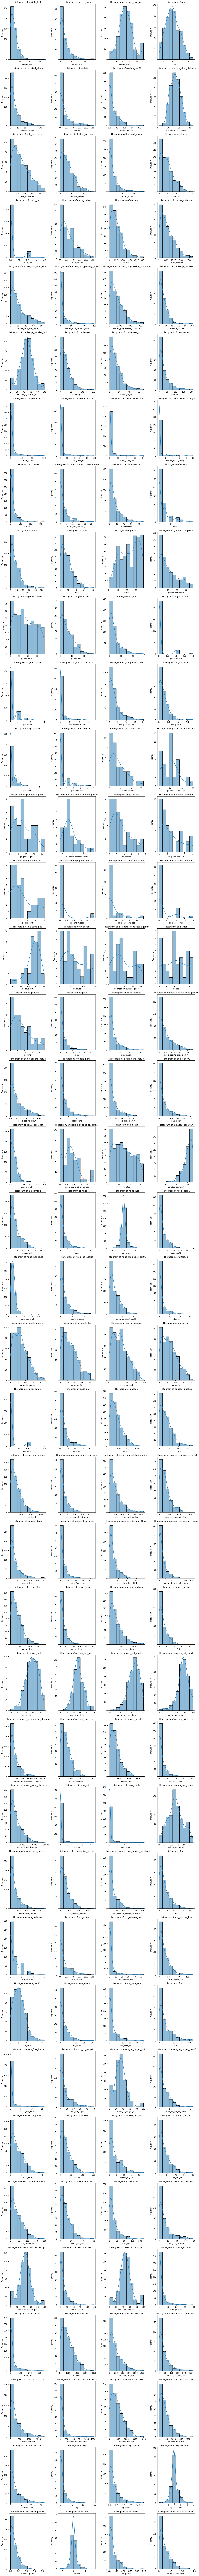

In [31]:
num_rows = (statistical_columns.size + AXES_PER_ROW - 1) // AXES_PER_ROW
fig, axes = plt.subplots(num_rows, AXES_PER_ROW, figsize=(15, 5 * num_rows))
axes = axes.flatten()

for i, column in enumerate(statistical_columns):
    sns.histplot(stats[column], ax=axes[i], bins=10, kde=True)
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [42]:
top_team_stats = stats[statistical_columns].groupby(level="team").agg("mean").apply(lambda col: col.idxmax())
print(*top_team_stats.items(), sep="\n")

('aerials_lost', 'Bournemouth')
('aerials_won', 'Everton')
('aerials_won_pct', "Nott'ham Forest")
('age', 'West Ham')
('assisted_shots', 'Liverpool')
('assists', 'Manchester City')
('assists_per90', 'Tottenham')
('average_shot_distance', 'Burnley')
('ball_recoveries', 'Liverpool')
('blocked_passes', 'Liverpool')
('blocked_shots', 'West Ham')
('blocks', 'West Ham')
('cards_red', 'Burnley')
('cards_yellow', 'Chelsea')
('carries', 'Manchester City')
('carries_distance', 'Manchester City')
('carries_into_final_third', 'Manchester City')
('carries_into_penalty_area', 'Manchester City')
('carries_progressive_distance', 'Manchester City')
('challenge_tackles', 'Fulham')
('challenge_tackles_pct', 'Arsenal')
('challenges', 'Liverpool')
('challenges_lost', 'Liverpool')
('clearances', 'West Ham')
('corner_kicks', 'Manchester City')
('corner_kicks_in', 'Arsenal')
('corner_kicks_out', 'Liverpool')
('corner_kicks_straight', 'Wolves')
('crosses', 'Liverpool')
('crosses_into_penalty_area', 'Fulham')
(